In [6]:
# !rm -rf /kaggle/working/

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
rm: cannot remove '/kaggle/working/': Device or resource busy


In [1]:
!git clone https://github.com/ml-repro-team-2/re-rosetta.git
%cd /kaggle/working/re-rosetta/
!git checkout aakash

Cloning into 're-rosetta'...
remote: Enumerating objects: 206, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 206 (delta 14), reused 15 (delta 14), pack-reused 188
Receiving objects: 100% (206/206), 42.28 MiB | 19.25 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/kaggle/working/re-rosetta
Branch 'aakash' set up to track remote branch 'aakash' from 'origin'.
Switched to a new branch 'aakash'


In [2]:
# !rm -rf /kaggle/working/re-rosetta/matches

In [3]:
!cp /kaggle/input/class-949/matches /kaggle/working/re-rosetta -r

In [4]:
!ls /kaggle/working/re-rosetta/matches/styleganxl/clip

812


In [5]:
## CONFIG
classid = 812
LOSS_TYPE = 'perceptual'

In [6]:
#@title Requirements
!pip install -r requirements.txt
!pip install transformers
!pip install openai-clip
!pip install einops
!pip install pytorch_pretrained_biggan
!pip install Ninja
!pip install timm==0.4.12
!pip install dill

  Cloning https://github.com/openai/CLIP.git (to revision b46f5ac7587d2e1862f8b7b1573179d80dcdd620) to /tmp/pip-install-iqnfw1qs/clip_425bba5ee8e24f1c9c3e868adae7c4b9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-iqnfw1qs/clip_425bba5ee8e24f1c9c3e868adae7c4b9
  Running command git rev-parse -q --verify 'sha^b46f5ac7587d2e1862f8b7b1573179d80dcdd620'
  Running command git fetch -q https://github.com/openai/CLIP.git b46f5ac7587d2e1862f8b7b1573179d80dcdd620
  Running command git checkout -q b46f5ac7587d2e1862f8b7b1573179d80dcdd620
  Resolved https://github.com/openai/CLIP.git to commit b46f5ac7587d2e1862f8b7b1573179d80dcdd620
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/arogozhnikov/einops.git (to revision d6f7910dc80c8413b7bb400f6f6ad24e3c5f5b0f) to /tmp/pip-install-iqnfw1qs/einops_0925403e1a0b45ff8b52273a676cb56b
  Running command git clone --filter=blob:none --quiet https://github.com/arogozhnikov/eino

In [7]:
!pip install gdown

  Obtaining dependency information for gdown from https://files.pythonhosted.org/packages/68/fb/c1bb2cfbf1ad068129e3d67f3420649d38183cca7118f4fa46cfe3c3adab/gdown-5.0.0-py3-none-any.whl.metadata


In [8]:
!gdown "https://drive.google.com/uc?export=download&id=1EX4J4Al5cGC8Z4ZPV5v576LBjLqw_Jt6" -O 'mae_pretrain_vit_base.pth'

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1EX4J4Al5cGC8Z4ZPV5v576LBjLqw_Jt6
From (redirected): https://drive.google.com/uc?export=download&id=1EX4J4Al5cGC8Z4ZPV5v576LBjLqw_Jt6&confirm=t&uuid=6c9a0dd3-7fcb-44dd-b7e2-04b97902e3ae
To: /kaggle/working/re-rosetta/mae_pretrain_vit_base.pth
100%|█████████████████████████████████████████| 343M/343M [00:02<00:00, 147MB/s]


In [9]:
import PIL
gan_mode = 'styleganxl'
discr_mode = 'resnet50'

## PAIRWISE MATCHING

In [10]:
from transformers import CLIPProcessor, CLIPModel
import torch
import torchvision
from torchvision.models import resnet50
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import clip
from PIL import Image
import requests
import torch.hub
import time
import pickle
import os
import numpy
import math
import match_utils
from match_utils import matching, stats, proggan, nethook, dataset, models, layers, loading, visualize_pairwisematch
device = torch.device('cuda')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
!rm -rf imgs

!mkdir -p imgs/dir0
!mkdir -p imgs/dir1

In [12]:
from torchvision import datasets
val_dataset = datasets.ImageFolder(root = '/kaggle/input/imagenet-val-mini/imagenet-val-mini')
fname = val_dataset.classes[classid]

In [13]:
ip = f"/kaggle/input/imagenet-val-mini/imagenet-val-mini/{fname}"
ip

'/kaggle/input/imagenet-val-mini/imagenet-val-mini/n04266014'

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 183MB/s] 


Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


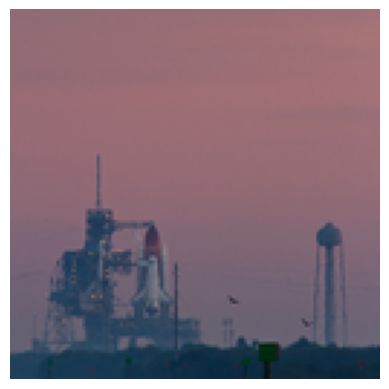

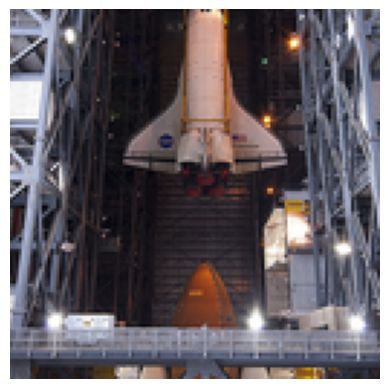

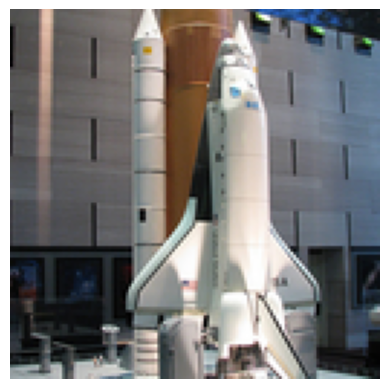

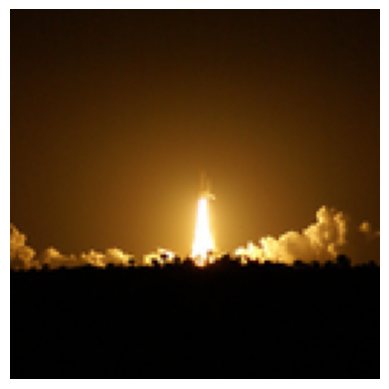

In [14]:
num_steps = 200
lr_rampdown_length = 0.25
lr_rampup_length = 0.05
initial_learning_rate = 0.01
seed = 35
torch.manual_seed(seed)
device = torch.device(device)

# Load models and tables
discr, discr_layers = models.load_discr(discr_mode, device)

G, gan_layers = models.load_gan(gan_mode, device)
ganlayers, discrlayers = layers.get_layers(
    G, gan_layers, discr, discr_layers, gan_mode, discr_mode, device
)
G = nethook.InstrumentedModel(G)
G.retain_layers(gan_layers, detach=False)
discr = nethook.InstrumentedModel(discr)
discr.retain_layers(discr_layers)

all_images = {}
files = os.listdir(ip)
for file in files:
    file = file
    biggan_resolution = 128
    target_fname = f"{ip}/{file}"
    target_pil = PIL.Image.open(target_fname).convert("RGB")
    w, h = target_pil.size
    s = min(w, h)
    target_pil = target_pil.crop(
        ((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2)
    )
    target_pil = target_pil.resize(
        (biggan_resolution, biggan_resolution), PIL.Image.LANCZOS
    )
    target_uint8 = np.array(target_pil, dtype=np.uint8)
    plt.imshow(target_uint8)
    plt.axis('off')
    plt.savefig((f"imgs/dir0/{file}"[:-4] + "png").lower(), bbox_inches="tight", pad_inches=-0.1)
    plt.show()

In [15]:

from scipy.stats import truncnorm


def truncate_noise(size, truncation):
    """
    Function for creating truncated noise vectors: Given the dimensions (n_samples, z_dim)
    and truncation value, creates a tensor of that shape filled with random
    numbers from the truncated normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        truncation: the truncation value, a non-negative scalar
    """

    truncated_noise = truncnorm.rvs(-1 * truncation, truncation, size=size)

    return torch.Tensor(truncated_noise)

In [16]:
# # target=torch.tensor(target_uint8.transpose([2, 0, 1]), device=device)


# for i in range(1, 10):
#     with open(f"imgs/dist{i}.txt", "w") as f:
#         f.write(f"{i}")

In [17]:
# k = 5
resnet_path = f"matches/{gan_mode}/{discr_mode}/{classid}"

table, gan_stats, discr_stats = loading.load_stats(resnet_path, device)
classs = classid

Loading...
Done


In [18]:
code = '''
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import torch
# from torch.autograd import Variable

from lpips.trainer import *
from lpips.lpips import *

def normalize_tensor(in_feat,eps=1e-10):
    norm_factor = torch.sqrt(torch.sum(in_feat**2,dim=1,keepdim=True))
    return in_feat/(norm_factor+eps)

def l2(p0, p1, range=255.):
    return .5*np.mean((p0 / range - p1 / range)**2)

def psnr(p0, p1, peak=255.):
    return 10*np.log10(peak**2/np.mean((1.*p0-1.*p1)**2))

def dssim(p0, p1, range=255.):
    from skimage.measure import compare_ssim
    return (1 - compare_ssim(p0, p1, data_range=range, multichannel=True)) / 2.

def tensor2np(tensor_obj):
    # change dimension of a tensor object into a numpy array
    return tensor_obj[0].cpu().float().numpy().transpose((1,2,0))

def np2tensor(np_obj):
     # change dimenion of np array into tensor array
    return torch.Tensor(np_obj[:, :, :, np.newaxis].transpose((3, 2, 0, 1)))

def tensor2tensorlab(image_tensor,to_norm=True,mc_only=False):
    # image tensor to lab tensor
    from skimage import color

    img = tensor2im(image_tensor)
    img_lab = color.rgb2lab(img)
    if(mc_only):
        img_lab[:,:,0] = img_lab[:,:,0]-50
    if(to_norm and not mc_only):
        img_lab[:,:,0] = img_lab[:,:,0]-50
        img_lab = img_lab/100.

    return np2tensor(img_lab)

def tensorlab2tensor(lab_tensor,return_inbnd=False):
    from skimage import color
    import warnings
    warnings.filterwarnings("ignore")

    lab = tensor2np(lab_tensor)*100.
    lab[:,:,0] = lab[:,:,0]+50

    rgb_back = 255.*np.clip(color.lab2rgb(lab.astype('float')),0,1)
    if(return_inbnd):
        # convert back to lab, see if we match
        lab_back = color.rgb2lab(rgb_back.astype('uint8'))
        mask = 1.*np.isclose(lab_back,lab,atol=2.)
        mask = np2tensor(np.prod(mask,axis=2)[:,:,np.newaxis])
        return (im2tensor(rgb_back),mask)
    else:
        return im2tensor(rgb_back)

def load_image(path):
    if(path[-3:] == 'dng'):
        import rawpy
        with rawpy.imread(path) as raw:
            img = raw.postprocess()
    elif(path[-3:]=='bmp' or path[-3:]=='jpg' or path[-3:]=='png' or path[-4:]=='jpeg'):
        import cv2
        return cv2.imread(path)[:,:,::-1]
    else:
        import matplotlib.pyplot as plt        
        img = (255*plt.imread(path)[:,:,:3]).astype('uint8')

    return img

def tensor2im(image_tensor, imtype=np.uint8, cent=1., factor=255./2.):
    image_numpy = image_tensor[0].cpu().float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + cent) * factor
    return image_numpy.astype(imtype)

def im2tensor(image, imtype=np.uint8, cent=1., factor=255./2.):
    return torch.Tensor((image / factor - cent)
                        [:, :, :, np.newaxis].transpose((3, 2, 0, 1)))

def tensor2vec(vector_tensor):
    return vector_tensor.data.cpu().numpy()[:, :, 0, 0]


def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap'''

In [19]:
!pip install lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.6 MB/s eta 0:00:00


In [20]:
with open("/opt/conda/lib/python3.10/site-packages/lpips/__init__.py","w") as f:
    f.write(code)

In [21]:
import torch.nn.functional as F

In [22]:
import lpips

In [23]:
import gc
gc.collect()
torch.cuda.empty_cache()

812 : ILSVRC2012_val_00005787.JPEG , initially generated image


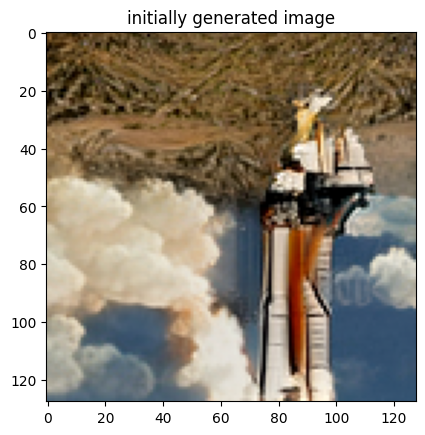

[ step   50/200] [ mse_loss: 3798.15][ a_loss: -0.05 loss_reg:  0.08] 
[ step  100/200] [ mse_loss: 2038.31][ a_loss: -0.07 loss_reg:  0.08] 
[ step  150/200] [ mse_loss: 1113.26][ a_loss: -0.06 loss_reg:  0.08] 
[ step  200/200] [ mse_loss: 978.95][ a_loss: -0.06 loss_reg:  0.08] 
inverted image - 812:ILSVRC2012_val_00005787.png
812 : ILSVRC2012_val_00033013.JPEG , initially generated image


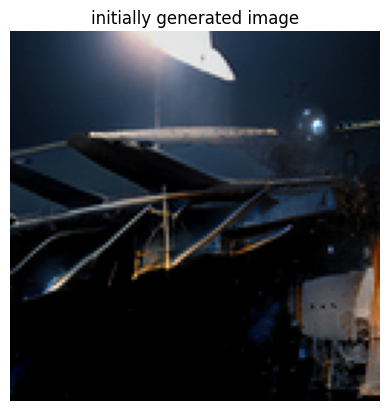

[ step   50/200] [ mse_loss: 3848.01][ a_loss: -0.10 loss_reg:  0.05] 
[ step  100/200] [ mse_loss: 1441.21][ a_loss: -0.10 loss_reg:  0.05] 
[ step  150/200] [ mse_loss: 772.85][ a_loss: -0.10 loss_reg:  0.05] 
[ step  200/200] [ mse_loss: 586.81][ a_loss: -0.09 loss_reg:  0.05] 
inverted image - 812:ILSVRC2012_val_00033013.png
812 : ILSVRC2012_val_00034371.JPEG , initially generated image


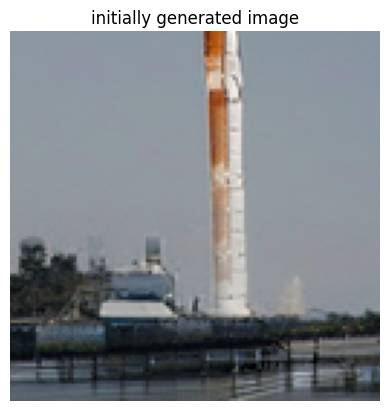

[ step   50/200] [ mse_loss: 1821.58][ a_loss: -0.04 loss_reg:  0.05] 
[ step  100/200] [ mse_loss: 260.97][ a_loss: -0.02 loss_reg:  0.05] 
[ step  150/200] [ mse_loss: 157.94][ a_loss: -0.02 loss_reg:  0.05] 
[ step  200/200] [ mse_loss: 144.67][ a_loss: -0.02 loss_reg:  0.05] 
inverted image - 812:ILSVRC2012_val_00034371.png
812 : ILSVRC2012_val_00049718.JPEG , initially generated image


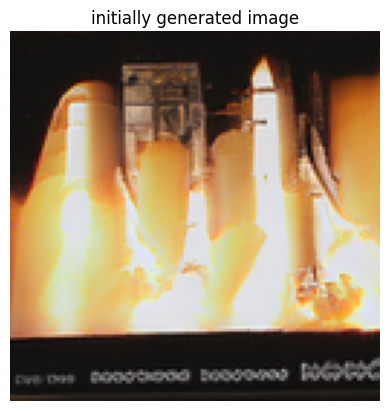

[ step   50/200] [ mse_loss: 1447.14][ a_loss: -0.18 loss_reg:  0.06] 
[ step  100/200] [ mse_loss: 583.28][ a_loss: -0.20 loss_reg:  0.06] 
[ step  150/200] [ mse_loss: 340.37][ a_loss: -0.20 loss_reg:  0.06] 
[ step  200/200] [ mse_loss: 272.69][ a_loss: -0.20 loss_reg:  0.06] 
inverted image - 812:ILSVRC2012_val_00049718.png


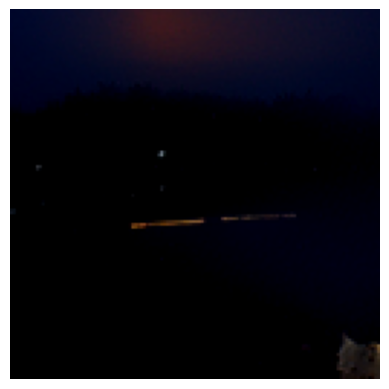

In [41]:
l2_criterion = torch.nn.MSELoss(reduction='mean')

for k in range(1, 2):
    gan_matches = torch.argmax(table, 1)
    _, discr_matches = torch.topk(table, k=k, dim=0)

    ##get best buddies
    perfect_matches = []
    discr_perfect_matches = []
    num_perfect_matches = 0
    for i in range(table.shape[0]):
        gan_match = gan_matches[i].item()
        discr_match = discr_matches[:, gan_match]
        if discr_match.ndim == 1:
            if i in discr_match:
                num_perfect_matches += 1
                perfect_matches.append(i)
                discr_perfect_matches.append(gan_match)
        else:
            if i == discr_match:
                num_perfect_matches += 1
                perfect_matches.append(i)
                discr_perfect_matches.append(gan_match)
    #     getting everything in (layer, unit) form
    for i, unit in enumerate(perfect_matches):
        perfect_matches[i] = layers.find_act(perfect_matches[i], ganlayers)
    for i, unit in enumerate(discr_perfect_matches):
        discr_perfect_matches[i] = layers.find_act(
            discr_perfect_matches[i], discrlayers
        )
    all_images = {}
    biggan_resolution = 128
    files = os.listdir(ip)
    for file in files:
        target_fname = f"{ip}/{file}"
        discr_im = Image.open(target_fname).convert("RGB")
        discr_im_np = discr_im
        discr_im = torchvision.transforms.ToTensor()(discr_im).unsqueeze(0).to(device)

        discr_im = torch.nn.functional.interpolate(
            discr_im, size=(224, 224), mode="bicubic"
        )
        discr_im = torchvision.transforms.Normalize(
            (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
        )(discr_im)
        #         plt.imshow(discr_im.squeeze().permute(1,2,0).cpu())
        #         plt.show()

        logits = discr(discr_im)
        assert(classid, torch.argmax(logits))
        discr_activs = matching.store_activs(discr, discr_layers)

        # normalize
        eps = 0.00001
        for i, _ in enumerate(discr_activs):
            discr_activs[i] = (discr_activs[i] - discr_stats[i][0]) / (
                discr_stats[i][1] + eps
            )

        discr_perfect_activs = []
        for idx in discr_perfect_matches:
            discr_perfect_activs.append(
                discr_activs[idx[0]][:, idx[1], :, :].unsqueeze(0)
            )

        #     target_images = target.unsqueeze(0).to(device).to(torch.float32)
        z = truncate_noise((1, 64), 1).to(device)
        c = torch.zeros((1, 1000)).to(device)
        c[0, classs] = 1
        im = G(z, c, 1)
        im = im[0].permute((1, 2, 0))
        im = (im + 1) / 2
        print(f"{classid} : {file} , initially generated image")
        plt.imshow(im.detach().cpu())
        plt.title('initially generated image')
        plt.show()
        z1 = torch.tensor(
            truncate_noise((1, 64), 1),
            dtype=torch.float32,
            device=device,
            requires_grad=True,
        ).to(
            device
        )  # pylint: disable=not-callable
        optimizer = torch.optim.Adam([z1], betas=(0.9, 0.999), lr=initial_learning_rate)
        # @title Inversion
        # all_images = []
        for step in range(num_steps):
            # Learning rate schedule.
            t = step / num_steps
            lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
            lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
            lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
            lr = initial_learning_rate * lr_ramp
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr

            # Synth images from opt_w.
            synth_images = G(z1, c, 1)

            # track images
            synth_images = (synth_images + 1) * (255 / 2)
            synth_images_np = (
                synth_images.clone()
                .detach()
                .permute(0, 2, 3, 1)
                .clamp(0, 255)
                .to(torch.uint8)[0]
                .cpu()
                .numpy()
            )
            #     all_images.append(synth_images_np)

            # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
            if synth_images.shape[2] > 256:
                synth_images = F.interpolate(synth_images, size=(256, 256), mode="area")

            gan_activs = matching.store_activs(G, gan_layers)
            # normalize all activations
            eps = 0.00001
            for i, _ in enumerate(gan_activs):
                gan_activs[i] = (gan_activs[i] - gan_stats[i][0]) / (
                    gan_stats[i][1] + eps
                )

            gan_perfect_activs = []
            for idx in perfect_matches:
                gan_perfect_activs.append(gan_activs[idx[0]][:, idx[1], :, :])

            # pearson correlation
            a_loss = 0
            counter = len(gan_perfect_activs)
            for i, _ in enumerate(gan_perfect_activs):
                map_size = max(
                    (gan_perfect_activs[i].shape[1], discr_perfect_activs[i].shape[1])
                )
                gan_activ_new = torch.nn.Upsample(
                    size=(map_size, map_size), mode="bilinear"
                )(gan_perfect_activs[i].unsqueeze(0))
                discr_activ_new = torch.nn.Upsample(
                    size=(map_size, map_size), mode="bilinear"
                )(discr_perfect_activs[i])
                prod = torch.einsum("aixy,ajxy->ij", gan_activ_new, discr_activ_new)
                div1 = torch.sum(gan_activ_new**2)
                div2 = torch.sum(discr_activ_new**2)
                corr = prod / torch.sqrt(div1 * div2)
                a_loss += corr

            a_loss *= -1
            a_loss = a_loss / counter
            l_reg = torch.mean((z1 - z) ** 2)
            
            # perceptual loss
            mse_loss = l2_criterion(synth_images, F.interpolate(discr_im, size=(128, 128), mode='area'))
            
            # Features for synth images.
            if LOSS_TYPE == 'perceptual':
                loss = mse_loss + 0.1 * l_reg
            else:
                loss = a_loss + 0 * l_reg
            
            # Step
            optimizer.zero_grad(set_to_none=True)

            loss.backward()
            optimizer.step()
            msg  = f'[ step {step+1:>4d}/{num_steps}] '
            msg += f'[ mse_loss: {float(mse_loss):<5.2f}]'
            msg += f'[ a_loss: {float(a_loss):5.2f} loss_reg: {0.1 * float(l_reg):5.2f}] '
            if (step+1)%50 == 0:
                print(msg) 
            if step == num_steps - 1:
                plt.imshow(synth_images_np)
                plt.axis("off")
                file = file[:-4] + "png"
                print(f"inverted image - {classid}:{file}")
                plt.savefig(f"imgs/dir1/{file}".lower(), bbox_inches="tight", pad_inches=-0.1)
                #         if step % 50 == 0:
                #             plt.imshow(synth_images_np)
                #             plt.show()
#                 command = f"python calc_metrics.py  --dir0 imgs/dir0 --dir1 imgs/dir1 -o imgs/dist{k}.txt --use_gpu --version 0.1"
#                 os.system(command)

In [42]:
command = f"python calc_metrics.py  --dir0 imgs/dir0 --dir1 imgs/dir1 -o imgs/dist.txt --use_gpu --version 0.1"
os.system(command)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/kaggle/working/re-rosetta/calc_metrics.py:92: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


100%|██████████| 4/4 [00:00<00:00,  7.07it/s]


LPIPS 0.769785
SSIM 0.3653197834895353
PSNR 9.953678227280271
RMSE 0.5290207182438165
LEN 4


0

In [43]:
!zip -r inversion_results.zip imgs

updating: imgs/ (stored 0%)
updating: imgs/dir0/ (stored 0%)
updating: imgs/dir0/ilsvrc2012_val_00033013.png (deflated 0%)
updating: imgs/dir0/ilsvrc2012_val_00005787.png (deflated 0%)
updating: imgs/dir0/ilsvrc2012_val_00049718.png (deflated 0%)
updating: imgs/dir0/ilsvrc2012_val_00034371.png (deflated 0%)
updating: imgs/dir1/ (stored 0%)
updating: imgs/dir1/ilsvrc2012_val_00033013.png (deflated 2%)
updating: imgs/dir1/ilsvrc2012_val_00005787.png (deflated 0%)
updating: imgs/dir1/ilsvrc2012_val_00049718.png (deflated 0%)
updating: imgs/dir1/ilsvrc2012_val_00034371.png (deflated 0%)
updating: imgs/dist.txt (deflated 41%)


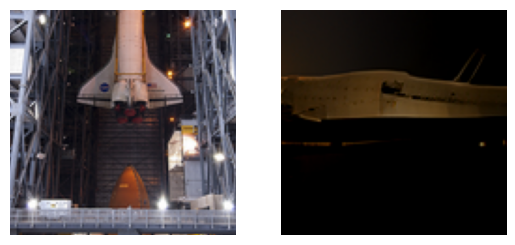

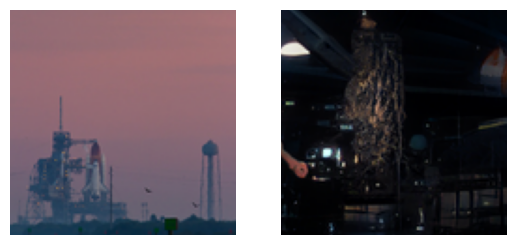

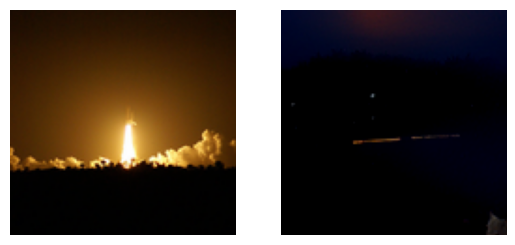

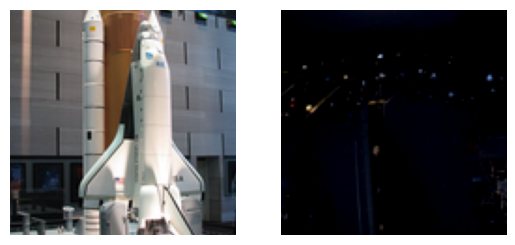

In [44]:
# display target images
for root, _, files in os.walk('imgs/dir0'):    
    for img_path in files:
        fig, axes = plt.subplots(1, 2)
        img1 = Image.open(os.path.join('imgs/dir0', img_path))
        img2 = Image.open(os.path.join('imgs/dir1', img_path))
        axes[0].imshow(img1)
        axes[0].set_axis_off()
        axes[1].imshow(img2)
        axes[1].set_axis_off()
        fig.show()